# Sensitivity analysis of damages calculations
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [2]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from functools import reduce
import matplotlib.patches as mpatches
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg

Location

In [3]:
loc_enso = "../Data/ENSO_Indices/CMIP6/"
loc_damages = "../Data/Damages/" 
loc_tc = "../Data/Teleconnections/CMIP6/"

Years

In [4]:
y1 = 2020
y2 = 2099

Warning

In [5]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample")

#### Analysis

Read E-index and damages

In [6]:
exps = ["ssp126","ssp245","ssp370","ssp585"]

In [7]:
persist = "partial"

In [8]:
for e in exps:
    print(e)
    
    enso_models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_files = np.array([loc_enso+m for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_ds = xr.open_mfdataset(enso_files,concat_dim="model",combine="nested")
    enso_ds.coords["model"] = enso_models
    alphas = enso_ds.alpha.load()
    alpha_threshold = -0.17 # half the obs value of -0.34
    e_index = enso_ds.e_index.load()
    c_index = enso_ds.c_index.load()
    e_shift = e_index.shift(time=1)
    e_djf = e_shift[:,e_shift.time.dt.month<=3].resample(time="YS").mean(dim="time")
    e_djf.coords["time"] = e_djf.time.dt.year.values
    
    models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1940" in m)])
    models_files = np.array([loc_tc+m for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1940" in m)])
    tc_ds = xr.open_mfdataset(models_files,concat_dim="model",combine="nested")
    tc_ds.coords["model"] = models
    tc_corr = tc_ds.teleconnections_corr_running.sel(index="e").load()
    
    if e=="ssp126":
        damages_e_126 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_126 = e_djf.loc[damages_e_126.model.values,:]
        tc_change_126 = tc_corr.loc[damages_e_126.model.values,"future",:] - tc_corr.loc[damages_e_126.model.values,"hist",:]
        tc_change_126_pct = 100*tc_change_126/tc_corr.loc[damages_e_126.model.values,"hist",:]
    elif e=="ssp245":
        damages_e_245 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_245 = e_djf.loc[damages_e_245.model.values,:]
        tc_change_245 = tc_corr.loc[damages_e_245.model.values,"future",:] - tc_corr.loc[damages_e_245.model.values,"hist",:]
        tc_change_245_pct = 100*tc_change_245/tc_corr.loc[damages_e_245.model.values,"hist",:]
    elif e=="ssp370":
        damages_e_370 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_370 = e_djf.loc[damages_e_370.model.values,:]
        tc_change_370 = tc_corr.loc[damages_e_370.model.values,"future",:] - tc_corr.loc[damages_e_370.model.values,"hist",:]
        tc_change_370_pct = 100*tc_change_370/tc_corr.loc[damages_e_370.model.values,"hist",:]
    elif e=="ssp585":
        damages_e_585 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_585 = e_djf.loc[damages_e_585.model.values,:]
        tc_change_585 = tc_corr.loc[damages_e_585.model.values,"future",:] - tc_corr.loc[damages_e_585.model.values,"hist",:]
        tc_change_585_pct = 100*tc_change_585/tc_corr.loc[damages_e_585.model.values,"hist",:]

ssp126
ssp245
ssp370
ssp585


In [9]:
amp_change_126 = 100*(e_126.loc[:,2020:2099].std(dim="time") - e_126.loc[:,1940:2019].std(dim="time"))/e_126.loc[:,1940:2019].std(dim="time")
amp_change_245 = 100*(e_245.loc[:,2020:2099].std(dim="time") - e_245.loc[:,1940:2019].std(dim="time"))/e_245.loc[:,1940:2019].std(dim="time")
amp_change_370 = 100*(e_370.loc[:,2020:2099].std(dim="time") - e_370.loc[:,1940:2019].std(dim="time"))/e_370.loc[:,1940:2019].std(dim="time")
amp_change_585 = 100*(e_585.loc[:,2020:2099].std(dim="time") - e_585.loc[:,1940:2019].std(dim="time"))/e_585.loc[:,1940:2019].std(dim="time")
amp_change_126_raw = e_126.loc[:,2020:2099].std(dim="time") - e_126.loc[:,1940:2019].std(dim="time")
amp_change_245_raw = e_245.loc[:,2020:2099].std(dim="time") - e_245.loc[:,1940:2019].std(dim="time")
amp_change_370_raw = e_370.loc[:,2020:2099].std(dim="time") - e_370.loc[:,1940:2019].std(dim="time")
amp_change_585_raw = e_585.loc[:,2020:2099].std(dim="time") - e_585.loc[:,1940:2019].std(dim="time")

In [10]:
y1_e_sum = 2020
y2_e_sum = 2099
e_126_future = e_126.loc[:,y1:y2] #- e_126.loc[:,y1:y2].mean()
e_245_future = e_245.loc[:,y1:y2] #- e_245.loc[:,y1:y2].mean()
e_370_future = e_370.loc[:,y1:y2] #- e_370.loc[:,y1:y2].mean()
e_585_future = e_585.loc[:,y1:y2] #- e_585.loc[:,y1:y2].mean()
e_sum_126 = e_126_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_245 = e_245_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_370 = e_370_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_585 = e_585_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")

skewness

In [11]:
e_skew_126 = np.zeros(len(e_sum_126))
e_skew_245 = np.zeros(len(e_sum_245))
e_skew_370 = np.zeros(len(e_sum_370))
e_skew_585 = np.zeros(len(e_sum_585))
for i in np.arange(0,len(e_sum_126),1):
    e_skew_126[i] = stats.skew(e_126_future[i,:].loc[y1_e_sum:y2_e_sum].values)
for i in np.arange(0,len(e_sum_245),1):
    e_skew_245[i] = stats.skew(e_245_future[i,:].loc[y1_e_sum:y2_e_sum].values)
for i in np.arange(0,len(e_sum_370),1):
    e_skew_370[i] = stats.skew(e_370_future[i,:].loc[y1_e_sum:y2_e_sum].values)
for i in np.arange(0,len(e_sum_585),1):
    e_skew_585[i] = stats.skew(e_585_future[i,:].loc[y1_e_sum:y2_e_sum].values)

Discounted damages

In [12]:
rates = np.array([0.01,0.02,0.03,0.05])
time = np.arange(y1,y2+1,1)
dfact = xr.DataArray(np.zeros((len(rates),len(time))),
                     coords=[rates,time],dims=["rate","time"])
for r in rates:
    dfact.loc[r,:] = np.exp(-1*r*(time-np.amin(time)))

In [13]:
damages_e_plot_126 = (damages_e_126.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_245 = (damages_e_245.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_370 = (damages_e_370.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_585 = (damages_e_585.gdp_change_global*dfact).sum(dim="time")/1e12

In [14]:
damages_126_median = damages_e_plot_126.sel(rate=0.02).median(dim=["boot"])
damages_245_median = damages_e_plot_245.sel(rate=0.02).median(dim=["boot"])
damages_370_median = damages_e_plot_370.sel(rate=0.02).median(dim=["boot"])
damages_585_median = damages_e_plot_585.sel(rate=0.02).median(dim=["boot"])

In [15]:
ssp_gdp_126_sum = (damages_e_126.ssp_gdp*dfact).sum(dim=["iso","time"]).sel(rate=0.02)/1e12
ssp_gdp_245_sum = (damages_e_245.ssp_gdp*dfact).sum(dim=["iso","time"]).sel(rate=0.02)/1e12
ssp_gdp_370_sum = (damages_e_370.ssp_gdp*dfact).sum(dim=["iso","time"]).sel(rate=0.02)/1e12
ssp_gdp_585_sum = (damages_e_585.ssp_gdp*dfact).sum(dim=["iso","time"]).sel(rate=0.02)/1e12

Read C-index damages

In [16]:
for e in exps:
    print(e)

    if e=="ssp126":
        damages_c_126 = xr.open_dataset(loc_damages+"CMIP6_Cindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp245":
        damages_c_245 = xr.open_dataset(loc_damages+"CMIP6_Cindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp370":
        damages_c_370 = xr.open_dataset(loc_damages+"CMIP6_Cindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp585":
        damages_c_585 = xr.open_dataset(loc_damages+"CMIP6_Cindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")

ssp126
ssp245
ssp370
ssp585


In [17]:
damages_c_plot_126 = (damages_c_126.gdp_change_global*dfact).sum(dim="time")/1e12
damages_c_plot_245 = (damages_c_245.gdp_change_global*dfact).sum(dim="time")/1e12
damages_c_plot_370 = (damages_c_370.gdp_change_global*dfact).sum(dim="time")/1e12
damages_c_plot_585 = (damages_c_585.gdp_change_global*dfact).sum(dim="time")/1e12

In [18]:
damages_both_plot_126 = damages_e_plot_126 + damages_c_plot_126
damages_both_plot_245 = damages_e_plot_245 + damages_c_plot_245
damages_both_plot_370 = damages_e_plot_370 + damages_c_plot_370
damages_both_plot_585 = damages_e_plot_585 + damages_c_plot_585

Now damages without teleconnection change

In [19]:
for e in exps:
    print(e)

    if e=="ssp126":
        damages_notc_126 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_notcchange_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp245":
        damages_notc_245 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_notcchange_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp370":
        damages_notc_370 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_notcchange_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp585":
        damages_notc_585 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_notcchange_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")

ssp126
ssp245
ssp370
ssp585


In [20]:
damages_notc_126_sum = (damages_notc_126.gdp_change_global*dfact).sum(dim="time")/1e12
damages_126_notc_median = damages_notc_126_sum.median(dim="boot").sel(rate=0.02)
damages_notc_245_sum = (damages_notc_245.gdp_change_global*dfact).sum(dim="time")/1e12
damages_245_notc_median = damages_notc_245_sum.median(dim="boot").sel(rate=0.02)
damages_notc_370_sum = (damages_notc_370.gdp_change_global*dfact).sum(dim="time")/1e12
damages_370_notc_median = damages_notc_370_sum.median(dim="boot").sel(rate=0.02)
damages_notc_585_sum = (damages_notc_585.gdp_change_global*dfact).sum(dim="time")/1e12
damages_585_notc_median = damages_notc_585_sum.median(dim="boot").sel(rate=0.02)

Damages with full persistence

In [21]:
for e in exps:
    print(e)

    if e=="ssp126":
        damages_fullpersist_126 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_fullpersistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp245":
        damages_fullpersist_245 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_fullpersistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp370":
        damages_fullpersist_370 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_fullpersistence_"+str(y1)+"-"+str(y2)+".nc")
    elif e=="ssp585":
        damages_fullpersist_585 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_fullpersistence_"+str(y1)+"-"+str(y2)+".nc")

ssp126
ssp245
ssp370
ssp585


In [22]:
damages_e_fullpersist_plot_126 = (damages_fullpersist_126.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_fullpersist_plot_245 = (damages_fullpersist_245.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_fullpersist_plot_370 = (damages_fullpersist_370.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_fullpersist_plot_585 = (damages_fullpersist_585.gdp_change_global*dfact).sum(dim="time")/1e12

Just one simulation from each model

In [24]:
models_subset_126_1 = ["MIROC-ES2L_r4i1p1f2","MIROC6_r1i1p1f1","MRI-ESM2-0_r1i1p1f1"]
models_subset_126_2 = ["MIROC-ES2L_r5i1p1f2","MIROC6_r2i1p1f1","MRI-ESM2-0_r2i1p1f1"]
models_subset_245_1 = ["CESM2-WACCM_r3i1p1f1","CMCC-CM2-SR5_r1i1p1f1","CMCC-ESM2_r1i1p1f1",\
                    "EC-Earth3_r7i1p1f1","MIROC-ES2L_r2i1p1f2","MIROC6_r1i1p1f1",\
                    "MPI-ESM1-2-HR_r2i1p1f1","MPI-ESM1-2-LR_r2i1p1f1","NorESM2-MM_r1i1p1f1"]
models_subset_245_2 = ["CESM2-WACCM_r2i1p1f1","CMCC-CM2-SR5_r1i1p1f1","CMCC-ESM2_r1i1p1f1",\
                    "EC-Earth3_r2i1p1f1","MIROC-ES2L_r1i1p1f2","MIROC6_r21i1p1f1",\
                    "MPI-ESM1-2-HR_r2i1p1f1","MPI-ESM1-2-LR_r3i1p1f1","NorESM2-MM_r1i1p1f1"]
models_subset_370_1 = ["CESM2-WACCM_r1i1p1f1","CMCC-CM2-SR5_r1i1p1f1","CMCC-ESM2_r1i1p1f1",\
                    "MIROC-ES2L_r1i1p1f2","MIROC6_r1i1p1f1","MPI-ESM1-2-HR_r3i1p1f1",\
                    "MPI-ESM1-2-LR_r2i1p1f1","MRI-ESM2-0_r1i1p1f1","NorESM2-LM_r1i1p1f1",\
                    "NorESM2-MM_r1i1p1f1"]
models_subset_370_2 = ["CESM2-WACCM_r1i1p1f1","CMCC-CM2-SR5_r1i1p1f1","CMCC-ESM2_r1i1p1f1",\
                    "MIROC-ES2L_r2i1p1f2","MIROC6_r2i1p1f1","MPI-ESM1-2-HR_r5i1p1f1",\
                    "MPI-ESM1-2-LR_r3i1p1f1","MRI-ESM2-0_r2i1p1f1","NorESM2-LM_r1i1p1f1",\
                    "NorESM2-MM_r1i1p1f1"]
models_subset_585_1 = ["CESM2-WACCM_r2i1p1f1","CESM2_r4i1p1f1","CMCC-CM2-SR5_r1i1p1f1",\
                    "CMCC-ESM2_r1i1p1f1","MIROC-ES2L_r1i1p1f2","MIROC6_r1i1p1f1",\
                    "MPI-ESM1-2-HR_r2i1p1f1","NorESM2-LM_r1i1p1f1","NorESM2-MM_r1i1p1f1"]
models_subset_585_2 = ["CESM2-WACCM_r2i1p1f1","CESM2_r11i1p1f1","CMCC-CM2-SR5_r1i1p1f1",\
                    "CMCC-ESM2_r1i1p1f1","MIROC-ES2L_r1i1p1f2","MIROC6_r2i1p1f1",\
                    "MPI-ESM1-2-HR_r2i1p1f1","NorESM2-LM_r1i1p1f1","NorESM2-MM_r1i1p1f1"]

Colors

In [26]:
scen_cols = ["sandybrown","salmon","red","darkred"]
scen_names = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]

Plot

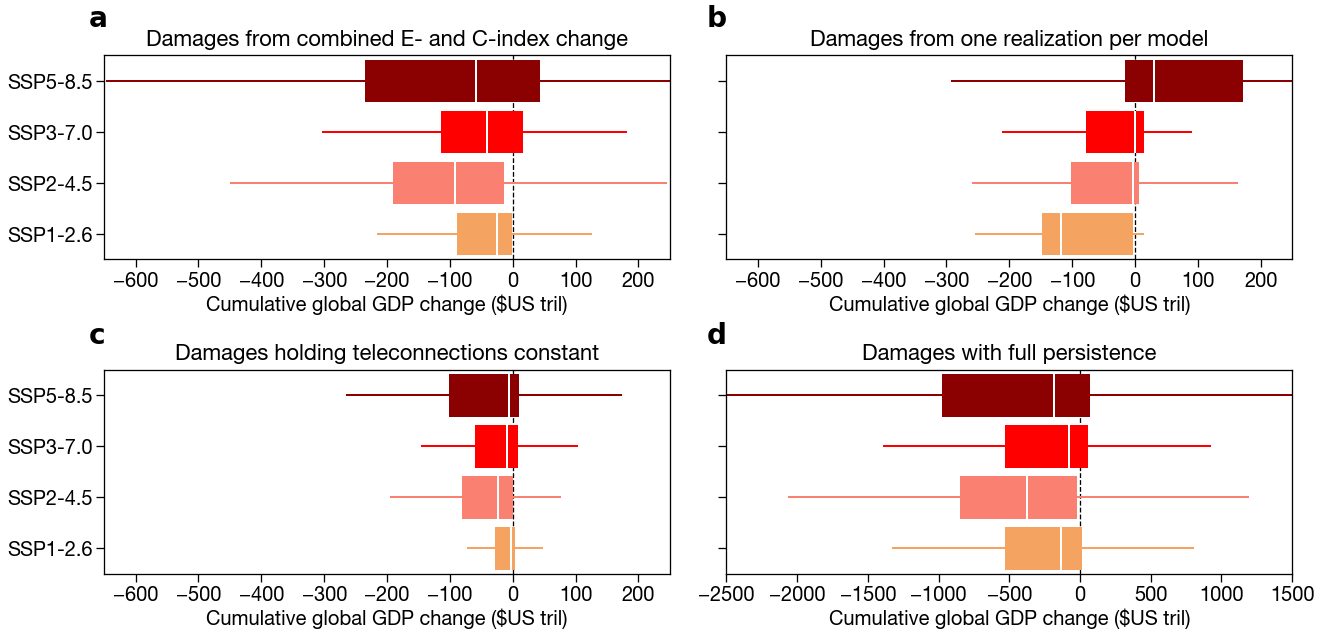

In [25]:
fig = plt.figure(figsize=(22,10))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22
textfs = 16

gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.18,right=0.93,top=0.87,bottom=0.15,wspace=0.1,hspace=0.54)

for j in [0,1,2,3]:
    ax = plt.subplot(gs1[j])
    plt.setp(ax.spines.values(), linewidth=1.3)
    overall_xlim = [-650,250]

    main_drate = 0.02

    scenario_pos = [1,2,3,4]
    for ee in np.arange(0,len(exps),1):
        e = exps[ee]
        #print(e)
        if j == 0:
            if e=="ssp126":
                damages_box = damages_both_plot_126.sel(rate=main_drate).values.flatten()
            elif e=="ssp245":
                damages_box = damages_both_plot_245.sel(rate=main_drate).values.flatten()
            elif e=="ssp370":
                damages_box = damages_both_plot_370.sel(rate=main_drate).values.flatten()
            elif e=="ssp585":
                damages_box = damages_both_plot_585.sel(rate=main_drate).values.flatten()
            xlim = [-650,250]
        elif j == 1:
            if e=="ssp126":
                damages_box = damages_e_plot_126.loc[:,models_subset_126_1,main_drate].values.flatten()
            elif e=="ssp245":
                damages_box = damages_e_plot_245.loc[:,models_subset_245_1,main_drate].values.flatten()
            elif e=="ssp370":
                damages_box = damages_e_plot_370.loc[:,models_subset_370_1,main_drate].values.flatten()
            elif e=="ssp585":
                damages_box = damages_e_plot_585.loc[:,models_subset_585_1,main_drate].values.flatten()
            xlim = [-650,250]
        elif j == 2:
            if e=="ssp126":
                damages_box = damages_notc_126_sum.sel(rate=main_drate).values.flatten()
                #print(np.nanmedian(damages_box))
            elif e=="ssp245":
                damages_box = damages_notc_245_sum.sel(rate=main_drate).values.flatten()
                #print(np.nanmedian(damages_box))
            elif e=="ssp370":
                damages_box = damages_notc_370_sum.sel(rate=main_drate).values.flatten()
                #print(np.nanmedian(damages_box))
            elif e=="ssp585":
                damages_box = damages_notc_585_sum.sel(rate=main_drate).values.flatten()
                #print(np.nanmedian(damages_box))
            xlim = [-650,250]
        elif j == 3:
            if e=="ssp126":
                damages_box = damages_e_fullpersist_plot_126.sel(rate=main_drate).values.flatten()
            elif e=="ssp245":
                damages_box = damages_e_fullpersist_plot_245.sel(rate=main_drate).values.flatten()
            elif e=="ssp370":
                damages_box = damages_e_fullpersist_plot_370.sel(rate=main_drate).values.flatten()
            elif e=="ssp585":
                damages_box = damages_e_fullpersist_plot_585.sel(rate=main_drate).values.flatten()
            xlim = [-2500,1500]
            
        b1 = plt.boxplot(damages_box,sym="",widths=0.8,
                    vert=False,positions=[scenario_pos[ee]],
                        showcaps=False,patch_artist=True)
        for m in range(0,2,1):
            if m == 0:
                b1["boxes"][m].set(color=scen_cols[ee],linewidth=2)
                b1["medians"][m].set(color="white",linewidth=2)
                b1["medians"][m].set(color="white",linewidth=2)
            b1["whiskers"][m].set(color=scen_cols[ee],linewidth=2)

        medn = np.median(damages_box)
        if medn<0:
            lb = r"$-$"+str(int(np.around(np.abs(medn))))+"T"
        else:
            lb = str(int(np.around(medn)))+"T"
        #plt.text(790,scenario_pos[ee]-0.2,lb,fontsize=textfs,
        #        color=scen_cols[ee])
        
    plt.xlim(xlim)
    plt.xlabel("Cumulative global GDP change ($US tril)")
    plt.axvline(x=0,linewidth=1.3,color="black",linestyle="--",zorder=1)
    lbs = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]
    if (j == 0)|(j==2):
        plt.yticks(ticks=scenario_pos,labels=lbs)
    else:
        plt.yticks(ticks=scenario_pos,labels=[])
    
    if j == 0:
        plt.title("Damages from combined E- and C-index change",fontsize=tfs,pad=10)
    elif j == 1:
        plt.title("Damages from one realization per model",fontsize=tfs,pad=10)
    elif j == 2:
        plt.title("Damages holding teleconnections constant",fontsize=tfs,pad=10)
    elif j == 3:
        plt.title("Damages with full persistence",fontsize=tfs,pad=10)
        
plt.figtext(0.17,0.91,r'$\bf{a}$',fontsize=28)
plt.figtext(0.56,0.91,r'$\bf{b}$',fontsize=28)
plt.figtext(0.17,0.47,r'$\bf{c}$',fontsize=28)
plt.figtext(0.56,0.47,r'$\bf{d}$',fontsize=28)


plt.savefig("../Figures/FigX_Damage_Sensitivity.pdf")
plt.show()